# BAO examples

In this notebook we will show how to perform BAO fits to data power spectrum.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [1]:
import numpy as np

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 31)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
pk = cosmo.get_fourier().pk_interpolator(of='delta_cb')(k, z=z)
b = 2.
f = cosmo.growth_rate(z)
shotnoise = 1 / 5e-4
volume = 1e10

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1001):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)
data, mocks = mocks[0], mocks[1:]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## BAO theory and broadbands
The BAO broadband can be parameterized as:
- $k$ powers, $\sum_{i} (k / k_{p})^{i}$
- as sum of TSC or PCS kernels, $\sum_{i} K(k / k_{p} - i)$
where typically $k_{p} = 2\pi / r_{s}$.

/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


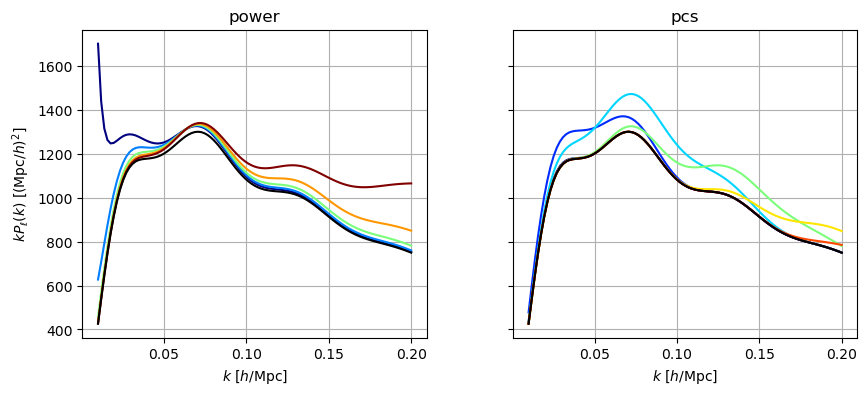

In [2]:
from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, DampedBAOWigglesTracerPowerSpectrumMultipoles

template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI')
theory = DampedBAOWigglesTracerPowerSpectrumMultipoles(template=template, broadband='power')

from matplotlib import pyplot as plt

fig, lax = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10, 4), squeeze=True)
fig.subplots_adjust(wspace=0.25)

for iax, broadband in enumerate(['power', 'pcs']):
    ax = lax[iax]
    theory.init.update(broadband=broadband)
    names = theory.all_params.names(basename='*l0*')
    cmap = plt.get_cmap('jet', len(names))
    for iname, name in enumerate(names):
        pk = theory(**{name: 5e2 if broadband == 'power' else 1.})
        for ill, ell in enumerate(theory.ells[:1]):
            ax.plot(theory.k, theory.k * pk[ill], color=cmap(iname * 1. / len(names)))
        pk = theory(**{name: 0.})
    ax.plot(theory.k, theory.k * pk[ill], color='k')
    ax.grid(True)
    ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
    lax[0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
    ax.set_title(broadband)
plt.show()

## BAO likelihood

In [3]:
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import setup_logging

theory.init.update(broadband='pcs')
# Set damping sigmas to zero, as data follows linear pk
for param in theory.init.params.select(basename='sigma*'):
    param.update(value=0., fixed=True)

# Analytically solve for broadband parameters (named 'al*_*')
for param in theory.init.params.select(basename='al*_*'):
    param.update(derived='.auto')
observable = TracerPowerSpectrumMultipolesObservable(data=data, covariance=mocks,
                                                     klim={0: [0.005, 0.2], 2: [0.005, 0.2]},  # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

setup_logging()

In [4]:
# Note, observable can take as input:
# - data: a (list of) (path to) PowerSpectrumStatistics object, flat array (see example below),
# or dictionary of parameters where to evaluate the theory to take as a mock data vector
# - covariance: a (list of) (path to) mocks, array (covariance matrix), or None (covariance passed to ObservablesGaussianLikelihood instead)

# Example, passing arrays:
ells = (0, 2)
k, pk = data(ell=ells, complex=False, return_k=True) # numpy array
mask = (k > 0.005) & (k < 0.2)
k = k[mask]  # array; one could also provide a list of k arrays, one for each ell
pk = np.ravel([pp[mask] for pp in pk])  # flat array
cov = np.cov([np.ravel([pp[mask] for pp in mock(ell=ells, complex=False)]) for mock in mocks], rowvar=False)  # array
observable = TracerPowerSpectrumMultipolesObservable(data=pk,
                                                     covariance=cov,
                                                     ells=ells,
                                                     k=k,
                                                     shotnoise=shotnoise,
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [5]:
from desilike.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 3 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiles = profiler.maximize(niterations=3)

[000000.08] [0/1] 11-02 15:49  MinuitProfiler            INFO     Varied parameters: ['qpar', 'qper', 'b1'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter loglikelihood of <desilike.likelihoods.base.SumLikelihood object at 0x7f8e63cdbfd0> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f8e63c77610>.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter logprior of <desilike.likelihoods.base.SumLikelihood object at 0x7f8e63cdbfd0> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f8e63c77610>.
  if self.mpicomm.rank == 0: warnings.warn(msg)


[000000.90] [0/1] 11-02 15:49  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000002.29] [0/1] 11-02 15:49  Differentiation           INFO     Differentiation will evaluate 1 points.
[000003.85] [0/1] 11-02 15:49  TaskManager               INFO     Entering TaskManager with 1 workers.


In [6]:
print(profiles.to_stats(tablefmt='pretty'))

+--------------------------------------+--------+---------+--------+
| chi2 / (38 - 17) = 18.55 / 21 = 0.88 | varied | bestfit | error  |
+--------------------------------------+--------+---------+--------+
|                 qpar                 |  True  | 1.0023  | 0.0038 |
|                 qper                 |  True  | 0.9978  | 0.0069 |
|                  b1                  |  True  |  1.959  | 0.069  |
|                al0_-1                |  True  |   3.5   |        |
|                al0_0                 |  True  |  0.21   |        |
|                al0_1                 |  True  |  0.10   |        |
|                al0_2                 |  True  |  0.18   |        |
|                al0_3                 |  True  |  0.074  |        |
|                al0_4                 |  True  |  0.69   |        |
|                al0_5                 |  True  |  -950   |        |
|                al2_-1                |  True  |  0.49   |        |
|                al2_0            

[000013.40] [0/1] 11-02 15:49  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000013.40] [0/1] 11-02 15:49  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000013.46] [0/1] 11-02 15:49  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000013.46] [0/1] 11-02 15:49  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


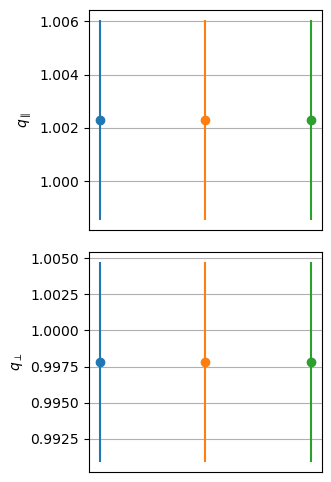

In [7]:
from desilike.samples import plotting
plotting.plot_aligned_stacked(profiles, params=['qpar', 'qper']);

/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter loglikelihood of <desilike.likelihoods.base.SumLikelihood object at 0x7f8e63b77520> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f8e63c77610>.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter logprior of <desilike.likelihoods.base.SumLikelihood object at 0x7f8e63b77520> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f8e63c77610>.
  if self.mpicomm.rank == 0: warnings.warn(msg)


[000013.76] [0/1] 11-02 15:49  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000014.19] [0/1] 11-02 15:49  Differentiation           INFO     Differentiation will evaluate 1 points.


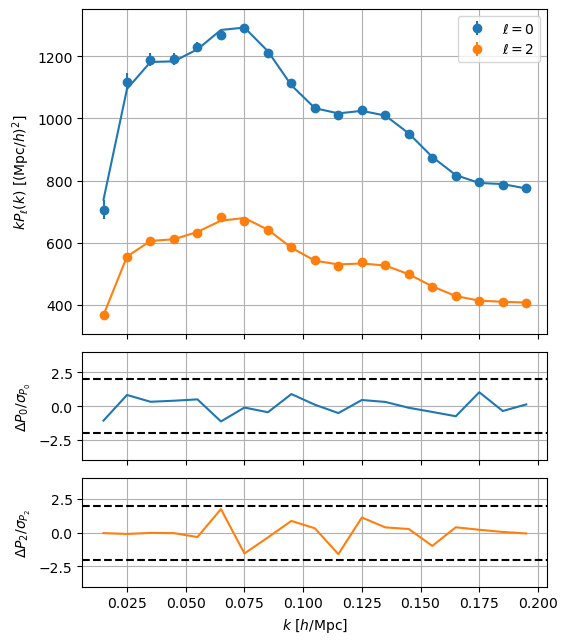

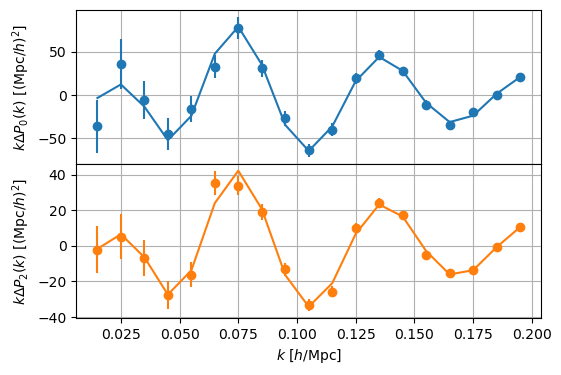

In [8]:
likelihood(**profiles.bestfit.choice(input=True))
observable.plot()
observable.plot_bao();

In [9]:
print(profiles.bestfit.choice(input=True))

{'qpar': 1.0022996085505014, 'qper': 0.9978114745047039, 'b1': 1.9592920569460544, 'df': 1.0, 'sigmas': 0.0, 'sigmapar': 0.0, 'sigmaper': 0.0, 'al0_-1': 3.495775842394267, 'al0_0': 0.20501192303354723, 'al0_1': 0.101642152230392, 'al0_2': 0.18171860206505114, 'al0_3': 0.0740986665362012, 'al0_4': 0.6851921165109971, 'al0_5': -947.7199853919589, 'al2_-1': 0.48579264151517004, 'al2_0': -0.016929690746983528, 'al2_1': 0.05679502013872198, 'al2_2': -0.015193926836123242, 'al2_3': 0.09506201628032859, 'al2_4': -0.19107891235623442, 'al2_5': 333.6858283377118}


## Detection level

In [10]:
likelihood()
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI', apmode='qiso', only_now=True)
theory.init.update(template=template)

profiler = MinuitProfiler(likelihood, seed=42)
grid = np.linspace(0.8, 1.2, 31)
profiler.maximize(niterations=1)
profiler.profile(params=['qiso'], grid=grid)
profiles_nowiggle = profiler.profiles

[000016.95] [0/1] 11-02 15:49  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter loglikelihood of <desilike.likelihoods.base.SumLikelihood object at 0x7f8e637bcb20> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f8e63c77610>.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter logprior of <desilike.likelihoods.base.SumLikelihood object at 0x7f8e637bcb20> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f8e63c77610>.
  if self.mpicomm.rank == 0: warnings.warn(msg)


[000017.60] [0/1] 11-02 15:49  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000019.56] [0/1] 11-02 15:49  Differentiation           INFO     Differentiation will evaluate 1 points.
[000020.85] [0/1] 11-02 15:49  TaskManager               INFO     Entering TaskManager with 1 workers.
[000023.81] [0/1] 11-02 15:49  TaskManager               INFO     Entering TaskManager with 1 workers.
[000023.87] [0/1] 11-02 15:49  TaskManager               INFO     Entering TaskManager with 1 workers.


In [11]:
template.init.update(only_now=False)

profiler = MinuitProfiler(likelihood, seed=42)
profiler.maximize(niterations=1)
print(profiler.profiles.to_stats(tablefmt='pretty'))

profiler.profile(params=['qiso'], grid=grid)
profiles = profiler.profiles

[000063.61] [0/1] 11-02 15:50  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter loglikelihood of <desilike.likelihoods.base.SumLikelihood object at 0x7f8e60a94940> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f8e63c77610>.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter logprior of <desilike.likelihoods.base.SumLikelihood object at 0x7f8e60a94940> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f8e63c77610>.
  if self.mpicomm.rank == 0: warnings.warn(msg)


[000064.19] [0/1] 11-02 15:50  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000066.13] [0/1] 11-02 15:50  Differentiation           INFO     Differentiation will evaluate 1 points.
[000067.33] [0/1] 11-02 15:50  TaskManager               INFO     Entering TaskManager with 1 workers.
+--------------------------------------+--------+---------+--------+
| chi2 / (38 - 16) = 19.40 / 22 = 0.88 | varied | bestfit | error  |
+--------------------------------------+--------+---------+--------+
|                 qiso                 |  True  | 1.0035  | 0.0036 |
|                  b1                  |  True  |  1.949  | 0.069  |
|                al0_-1                |  True  |   3.6   |        |
|                al0_0                 |  True  |  0.25   |        |
|                al0_1                 |  True  |  0.10   |        |
|                al0_2  

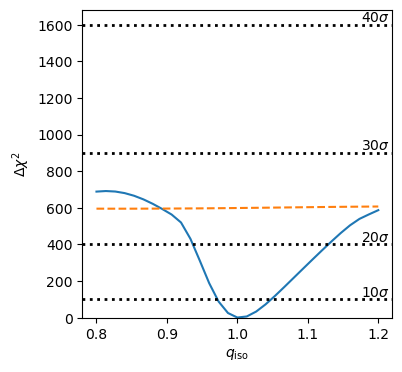

In [12]:
plotting.plot_profile_comparison(profiles, profiles_nowiggle, cl=[10, 20, 30, 40]);

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [13]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, save_fn='_tests/chain_bao_*.npy', seed=42)
sampler.run(min_iterations=500, check={'max_eigen_gr': 0.05, 'stable_over': 1})

[000114.50] [0/1] 11-02 15:51  EmceeSampler              INFO     Varied parameters: ['qiso', 'b1'].
[000114.98] [0/1] 11-02 15:51  TaskManager               INFO     Entering TaskManager with 1 workers.
[000225.90] [0/1] 11-02 15:53  Chain                     INFO     Saving _tests/chain_bao_0.npy.
[000225.91] [0/1] 11-02 15:53  EmceeSampler              INFO     Diagnostics:
[000225.93] [0/1] 11-02 15:53  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.041; < 0.05.
[000225.94] [0/1] 11-02 15:53  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0388.
[000226.10] [0/1] 11-02 15:53  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.173.
[000226.10] [0/1] 11-02 15:53  EmceeSampler              INFO     - max Geweke is 0.597.
[000226.11] [0/1] 11-02 15:53  EmceeSampler              INFO     - Geweke p-value is 0.761.
[000226.12] [0/1] 11-02 15:53  EmceeSampler              INFO     - (150 iterations / integrated autoc

/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000226.49] [0/1] 11-02 15:53  TaskManager               INFO     Entering TaskManager with 1 workers.
[000338.09] [0/1] 11-02 15:55  Chain                     INFO     Saving _tests/chain_bao_0.npy.
[000338.11] [0/1] 11-02 15:55  EmceeSampler              INFO     Diagnostics:
[000338.12] [0/1] 11-02 15:55  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.143; not < 0.05.
[000338.14] [0/1] 11-02 15:55  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.112.
[000338.42] [0/1] 11-02 15:55  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.486.
[000338.43] [0/1] 11-02 15:55  EmceeSampler              INFO     - max Geweke is 0.316.
[000338.43] [0/1] 11-02 15:55  EmceeSampler              INFO     - Geweke p-value is 0.639.
[000338.44] [0/1] 11-02 15:55  EmceeSampler              INFO     - (300 iterations / integrated autocorrelation time) is 15.5.
[000338.44] [0/1] 11-02 15:55  EmceeSampler              INFO     - max 

[Chain(shape=(2400, 6), params=ParameterCollection(['qiso', 'b1', 'logposterior', 'df', 'sigmas', 'sigmapar', 'sigmaper', 'DM_over_rd', 'DH_over_rd', 'DH_over_DM', 'DV_over_rd', 'loglikelihood', 'logprior', 'al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5']))]

In [14]:
chain = sampler.chains[0].remove_burnin(0.5)[::10]
print(chain.to_stats(tablefmt='pretty'))

+--------+--------+--------+--------+--------+-----------------+-----------------+
|        | argmax |  mean  | median |  std   | quantile:1sigma | interval:1sigma |
+--------+--------+--------+--------+--------+-----------------+-----------------+
|  qiso  | 1.0035 | 1.0035 | 1.0035 | 0.0035 | -0.0035/+0.0035 | -0.0041/+0.0029 |
|   b1   | 1.948  | 1.945  | 1.942  | 0.070  |  -0.069/+0.071  |  -0.074/+0.063  |
| al0_-1 |  3.6   |  3.6   |  3.6   |  2.7   |    -2.7/+2.7    |    -2.8/+2.7    |
| al0_0  |  0.25  |  0.26  |  0.28  |  0.38  |   -0.38/+0.37   |   -0.35/+0.39   |
| al0_1  |  0.11  |  0.11  |  0.12  |  0.23  |   -0.23/+0.23   |   -0.20/+0.25   |
| al0_2  |  0.21  |  0.22  |  0.24  |  0.32  |   -0.32/+0.32   |   -0.30/+0.34   |
| al0_3  |  0.02  |  0.02  |  0.02  |  0.26  |   -0.26/+0.26   |   -0.25/+0.26   |
| al0_4  |  1.1   |  1.2   |  1.2   |  1.1   |    -1.1/+1.1    |    -1.1/+1.1    |
| al0_5  | -1600  | -1600  | -1600  |  1300  |   -1300/+1200   |   -1300/+1200   |
| al

Removed no burn in


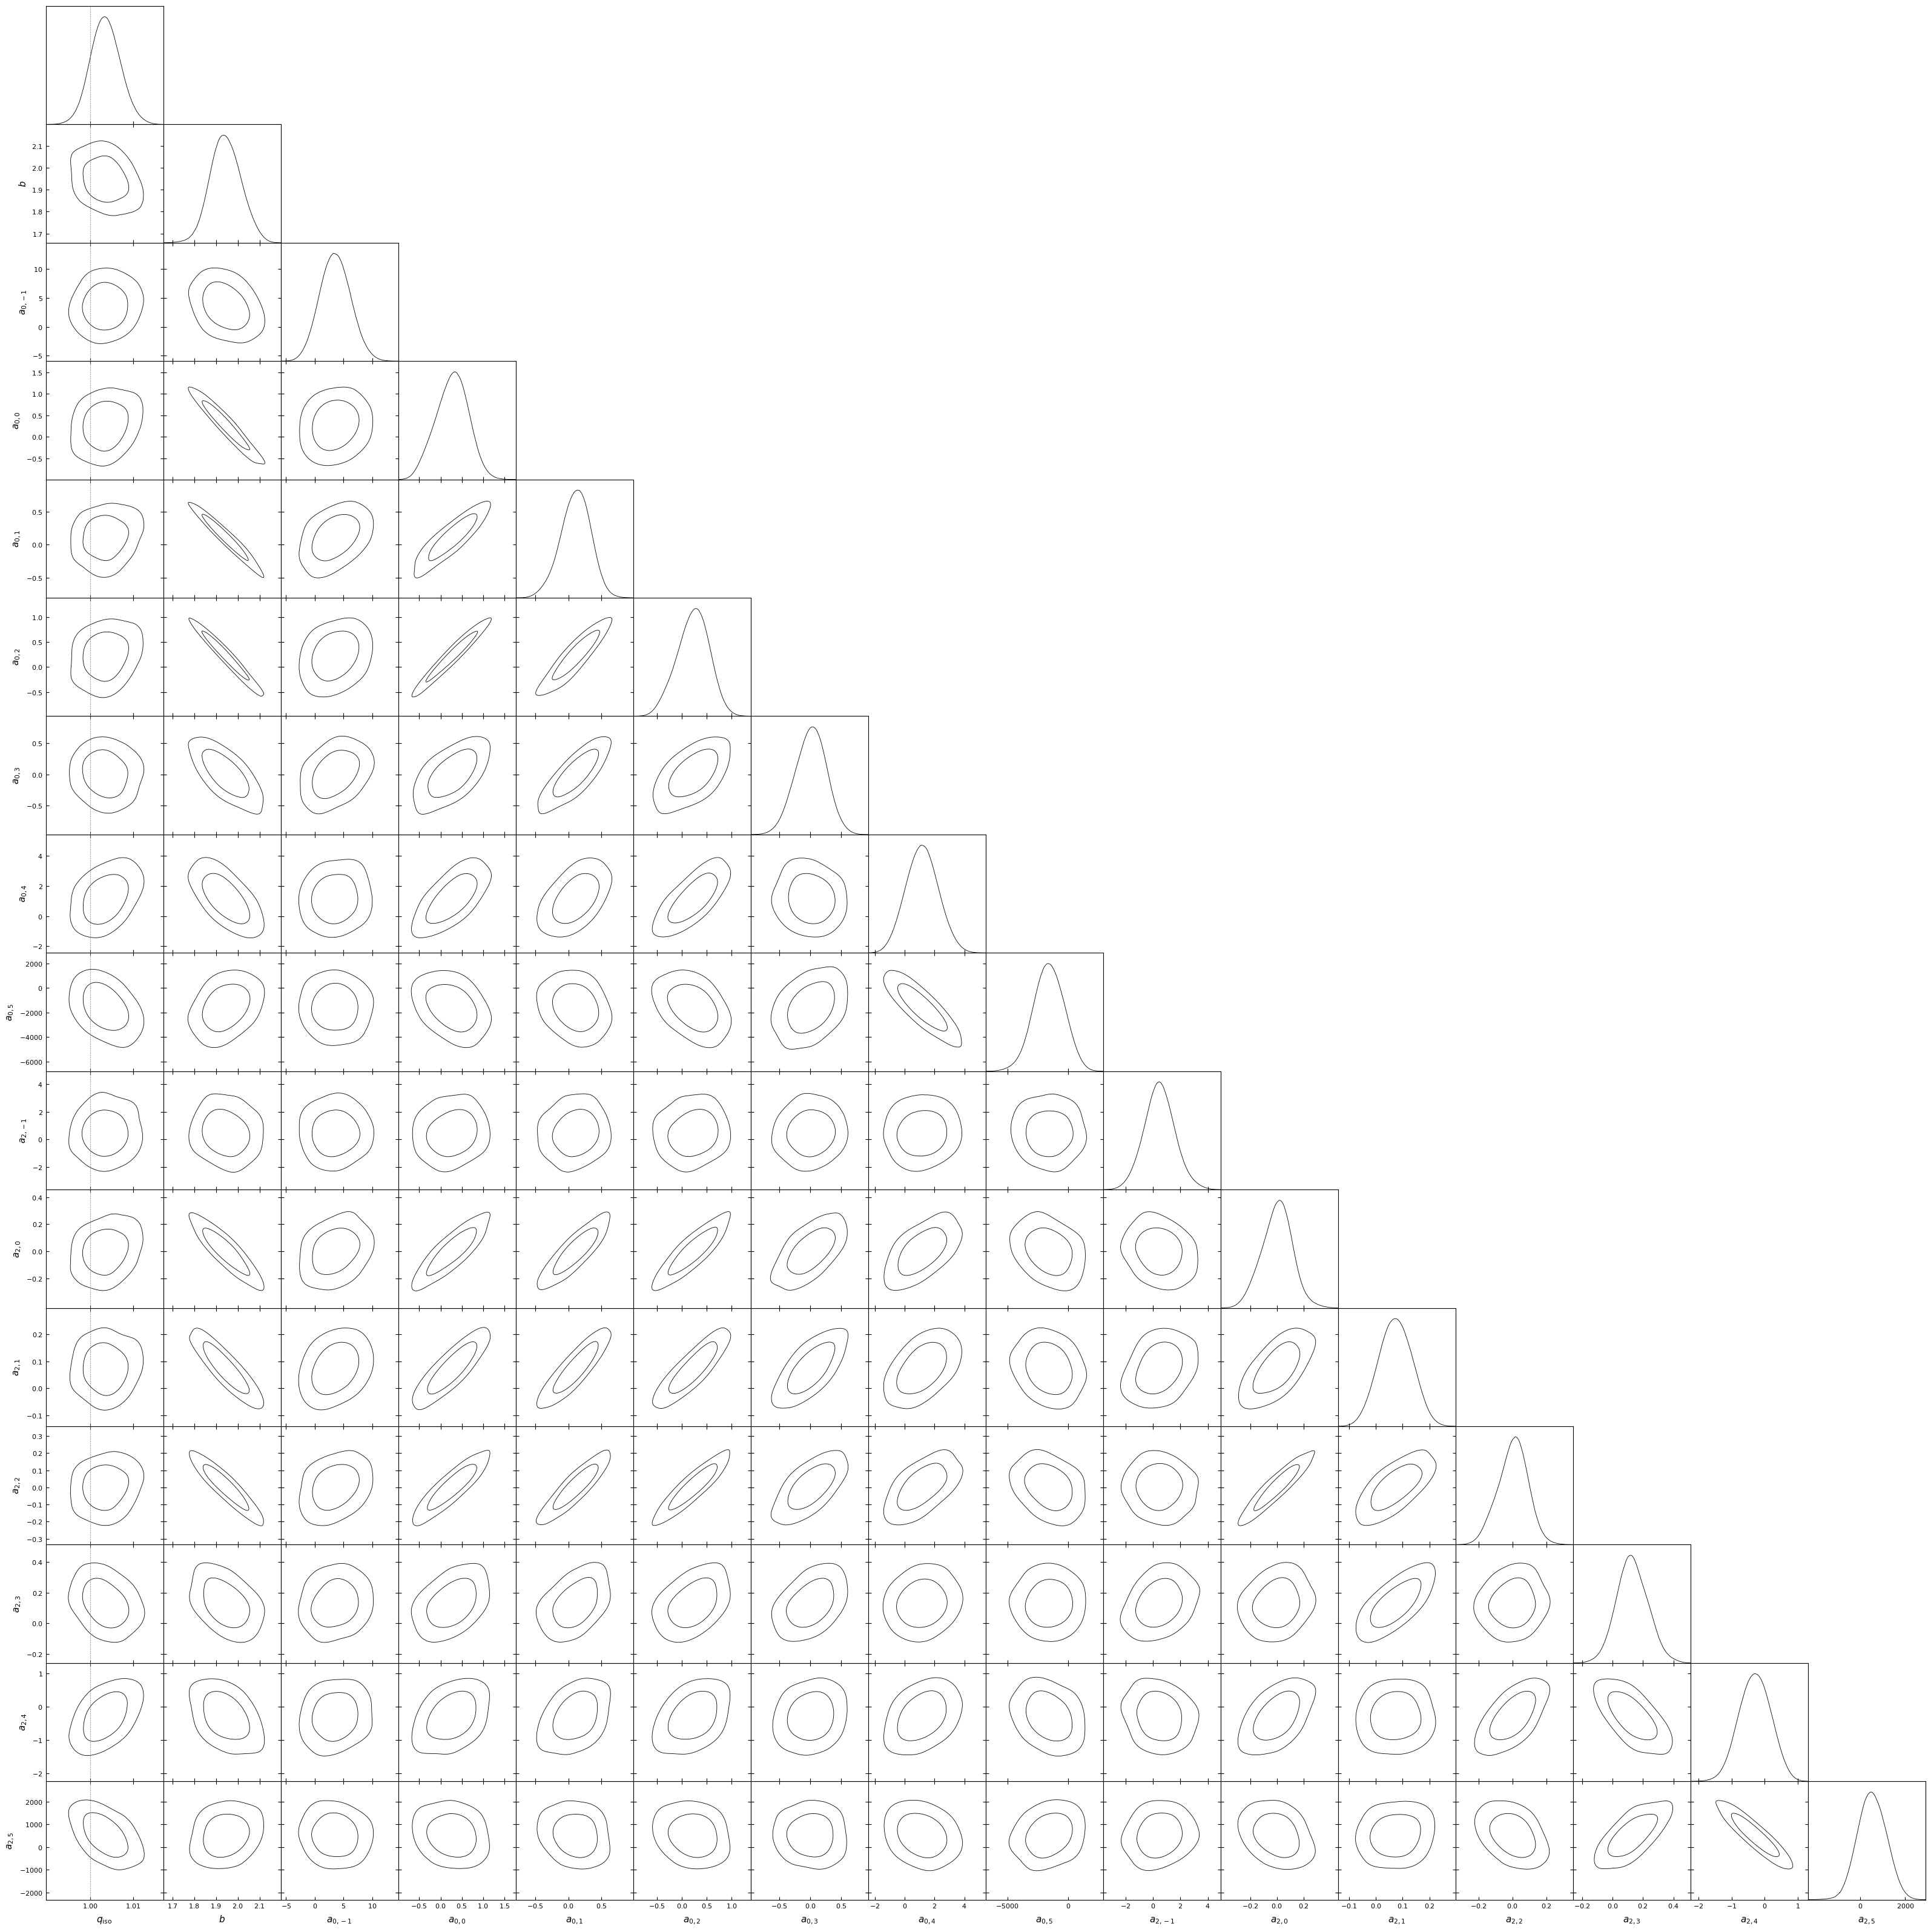

In [15]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'qiso': 1.})

## Trick: project out the broadband terms from the precision matrix

Since the gradient of the BAO model w.r.t. broadband parameters is constant (does not depend on the other theory parameters), we can just assign an infinite variance to these modes, i.e. redefine the precision matrix $\mathbf{C}^{-1}$ as: $\mathbf{C}^{-1} - \mathbf{C}^{-1} \mathbf{T} \mathbf{H}^{-1} \mathbf{T}^{T} \mathbf{C}^{-1}$ where $\mathbf{H} = \mathbf{T}^{T} \mathbf{C}^{-1} \mathbf{T} + \mathbf{P}$ is the Hessian, $\mathbf{P}$ the prior covariance on template parameters. Sampling is much faster --- but the posterior of broadband parameters is not saved.

In [16]:
from desilike.samplers import EmceeSampler

for param in likelihood.all_params.select(basename='al*_*'):
    param.update(derived='.prec')
sampler = EmceeSampler(likelihood, seed=42)
sampler.run(min_iterations=500, check={'max_eigen_gr': 0.05, 'stable_over': 1})

/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter loglikelihood of <desilike.likelihoods.base.SumLikelihood object at 0x7f8e607b7e20> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f8e63c77610>.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter logprior of <desilike.likelihoods.base.SumLikelihood object at 0x7f8e607b7e20> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f8e63c77610>.
  if self.mpicomm.rank == 0: warnings.warn(msg)


[001148.28] [0/1] 11-02 16:08  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[001148.96] [0/1] 11-02 16:08  Differentiation           INFO     Differentiation will evaluate 1 points.
[001149.82] [0/1] 11-02 16:08  EmceeSampler              INFO     Varied parameters: ['qiso', 'b1'].
[001149.95] [0/1] 11-02 16:08  TaskManager               INFO     Entering TaskManager with 1 workers.
[001159.36] [0/1] 11-02 16:08  EmceeSampler              INFO     Diagnostics:
[001159.38] [0/1] 11-02 16:08  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.041; < 0.05.
[001159.39] [0/1] 11-02 16:08  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0388.
[001159.57] [0/1] 11-02 16:08  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.173.
[001159.57] [0/1] 11-02 16:08  EmceeSampler              INF

/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[001169.08] [0/1] 11-02 16:08  EmceeSampler              INFO     Diagnostics:
[001169.09] [0/1] 11-02 16:08  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.143; not < 0.05.
[001169.10] [0/1] 11-02 16:08  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.112.
[001169.40] [0/1] 11-02 16:08  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.486.
[001169.40] [0/1] 11-02 16:08  EmceeSampler              INFO     - max Geweke is 0.316.
[001169.41] [0/1] 11-02 16:08  EmceeSampler              INFO     - Geweke p-value is 0.639.
[001169.42] [0/1] 11-02 16:08  EmceeSampler              INFO     - (300 iterations / integrated autocorrelation time) is 15.5.
[001169.42] [0/1] 11-02 16:08  EmceeSampler              INFO     - max variation of integrated autocorrelation time is 0.429.
[001169.45] [0/1] 11-02 16:08  TaskManager               INFO     Entering TaskManager with 1 workers.
[001178.83] [0/1] 11-02 16:09  EmceeSample

[Chain(shape=(2400, 6), params=ParameterCollection(['qiso', 'b1', 'logposterior', 'df', 'sigmas', 'sigmapar', 'sigmaper', 'DM_over_rd', 'DH_over_rd', 'DH_over_DM', 'DV_over_rd', 'loglikelihood', 'logprior']))]

+------+--------+--------+--------+--------+-----------------+-----------------+
|      | argmax |  mean  | median |  std   | quantile:1sigma | interval:1sigma |
+------+--------+--------+--------+--------+-----------------+-----------------+
| qiso | 1.0035 | 1.0035 | 1.0035 | 0.0035 | -0.0035/+0.0035 | -0.0041/+0.0029 |
|  b1  | 1.948  | 1.945  | 1.942  | 0.070  |  -0.069/+0.071  |  -0.074/+0.063  |
+------+--------+--------+--------+--------+-----------------+-----------------+
Removed no burn in
Removed no burn in


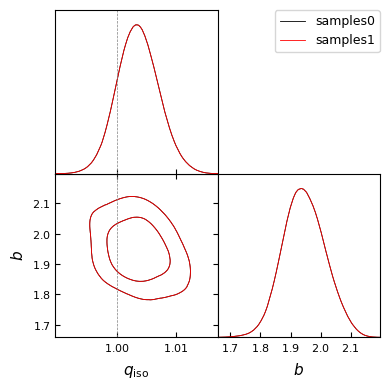

In [17]:
chain_prec = sampler.chains[0].remove_burnin(0.5)[::10]
print(chain_prec.to_stats(tablefmt='pretty'))

from desilike.samples import plotting
plotting.plot_triangle([chain, chain_prec], markers={'qiso': 1.})

## Post-processing
Let's use this BAO measurement to put constraints on $\Omega_{m}$.

In [18]:
from desilike.observables.galaxy_clustering import BAOCompressionObservable
observable = BAOCompressionObservable(data=chain, covariance=chain, z=z, quantities=['qiso'], fiducial='DESI')
likelihood = ObservablesGaussianLikelihood(observables=[observable])

In [19]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.02})

[001233.61] [0/1] 11-02 16:09  BAOCompressionObservable  INFO     Found quantities ['qiso'].
[001233.75] [0/1] 11-02 16:09  EmceeSampler              INFO     Varied parameters: ['Omega_m'].
[001234.22] [0/1] 11-02 16:09  TaskManager               INFO     Entering TaskManager with 1 workers.
[001343.68] [0/1] 11-02 16:11  EmceeSampler              INFO     Diagnostics:
[001343.69] [0/1] 11-02 16:11  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is -0.00295; < 0.02.
[001343.69] [0/1] 11-02 16:11  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is -0.00295.
[001343.77] [0/1] 11-02 16:11  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.111.
[001343.77] [0/1] 11-02 16:11  EmceeSampler              INFO     - max Geweke is 0.934.
[001343.77] [0/1] 11-02 16:11  EmceeSampler              INFO     - Geweke p-value is nan.
[001343.78] [0/1] 11-02 16:11  EmceeSampler              INFO     - (150 iterations / integrated autocorre

[Chain(shape=(600, 4), params=ParameterCollection(['Omega_m', 'logposterior', 'loglikelihood', 'logprior']))]

Removed no burn in


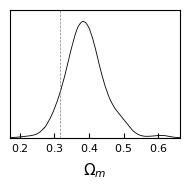

In [20]:
from desilike.samples import plotting
chain = sampler.chains[0].remove_burnin(0.4)
fiducial = observable.extractor.fiducial
plotting.plot_triangle(chain, markers={'Omega_m': fiducial.Omega0_m})